# RL Lab 03 - Part 1- Monte Carlo predicition on BlackJack

## 1. Monte Carlo prediction

In these exercises, we will explore the **the Monte Carlo prediction algorithhm**. <br>

The algorithm is shown on the [course slide deck.](https://centralesupelec.edunao.com/pluginfile.php/221332/mod_resource/content/1/2122-RL-Lecture04.pdf)<br>
The algorithm will be tested on Blackjack. <br>

### 1.1 Setup

In [1]:
!pip install gym
# !pip install plotting
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plotting.py

     |████████████████████████████████| 721 kB 4.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827635 sha256=263eb534638652fd8f0d6d2edf8d3e5a7fd41db89a2e4aaca617926e83057cc2
  Stored in directory: /Users/anmol345/Library/Caches/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym
--2023-03-14 13:39:36--  https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4251 (4.2K) [text/plain]
Saving to: 'blackjack.py'

blackjack.py        100%[===================>]   4.15K  --.-KB/s    in 0s  

In [2]:
# imports
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict


from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

### BlackJack Rules

First, we define the Blackjack environment:

<ul>
<li />Black Jack is a card game where a player must obtain cards such that their sum is as close to 21 without exceeding it.
<li />Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
<li />In our example below, the player plays against a dealer. The dealer has a fixed policy of always asking for an additional card until the sum of their cards is above 17. 
<li /> Stationarity: This game is placed with an infinite deck (or with replacement).
</ul>

Game Process:
<ol>
<li /> The game starts with each (player and dealer) having one face up and one
    face down card.
<li /> The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
<li />If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
</ol>
<img src="https://youngho92.github.io/images/RL/procedure.png" width="800">

In [3]:
env = BlackjackEnv()

### 1.2 Monte Carlo prediction

Recall that the Monte Carlo prediction algorithm provides a method for evaluating a given policy ($\pi$), that is obtain its value for each state $V(s)\;\;\forall s \in S$. 

It is similar to the policy evaluation step used in policy iteration for MDPs. The main difference is that **here we do not know the transition probabilities** and so we will have an agent that tries out the policy in the environment and, episode by episode, calculates the value function of the policy.

You need to write a function that evaluates the values of each states given a policy. <br>




In [5]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, plot_every=False):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode]) 
        for state in states_in_episode:
            # Find the first occurence of the state in the episode
            first_occurence_idx =  next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G =  sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] +=  G
            returns_count[state] +=  1.0
            V[state] =  returns_sum[state] / returns_count[state]
            
        if plot_every and i_episode % plot_every ==0:
            plotting.plot_value_function(V, title=f"{i_episode} Steps")

    return V    

Now, we will define a simple policy which we will evaluate. <br>
Specifically, **the policy hits except when the sum of the card is 20 or 21.**

In [6]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

We now evaluate the policy for 20k iterations. <br>


Episode 20000/20000.

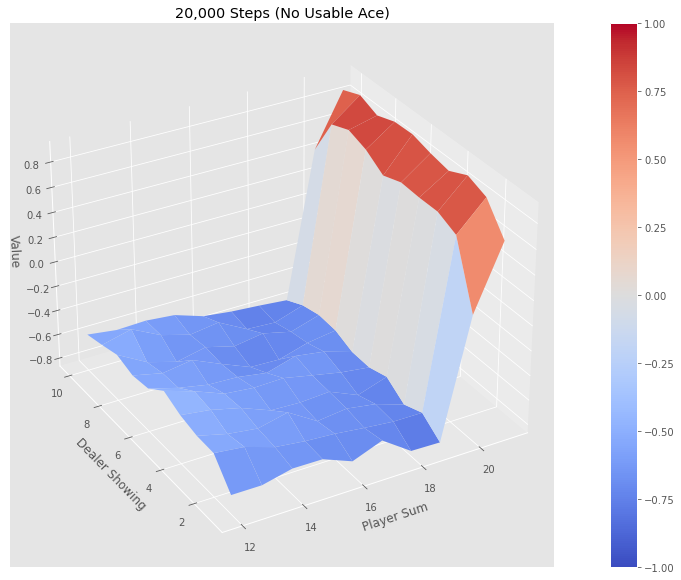

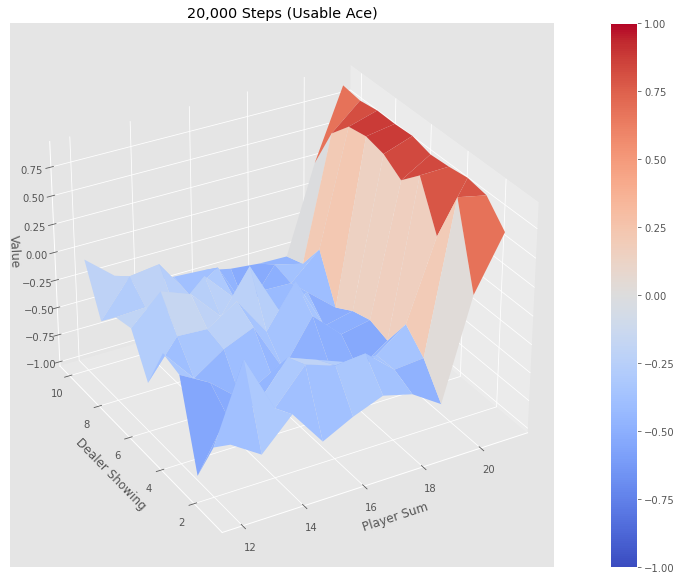

In [7]:
V_20k = mc_prediction(sample_policy, env, num_episodes=20000)
plotting.plot_value_function(V_20k, title="20,000 Steps")

## Question
Can you interpret the graph ?

Answer: XXXX


### 1.3 Monte Carlo prediction on multiple episodes

In this part we will analyze the effect of the number of episodes (num_episodes) on the learned value function.

Episode 10000/200000.

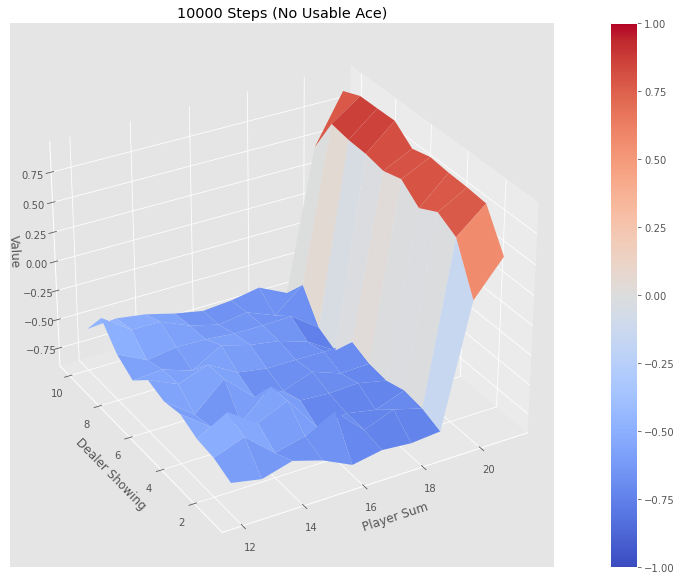

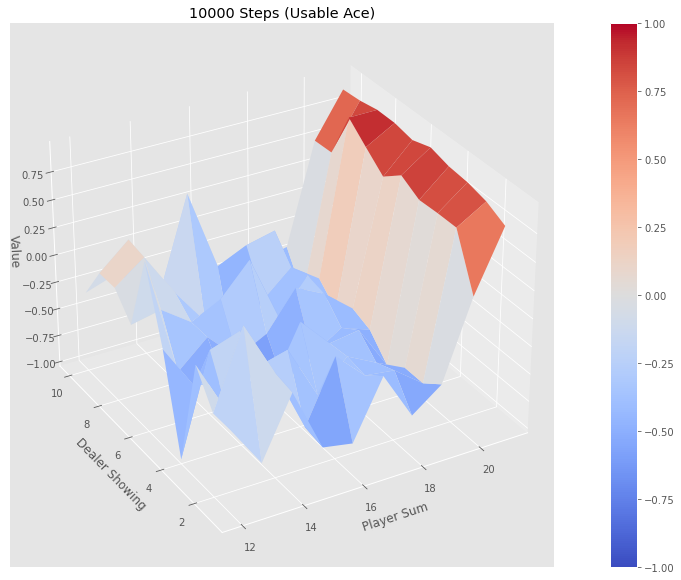

Episode 20000/200000.

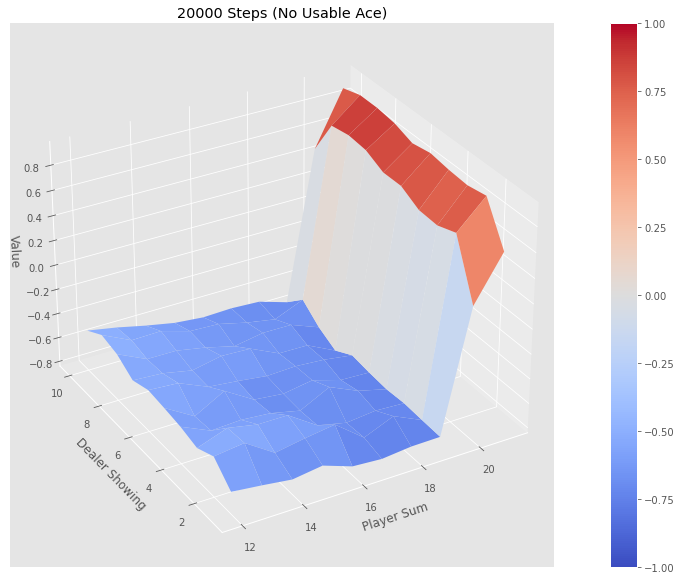

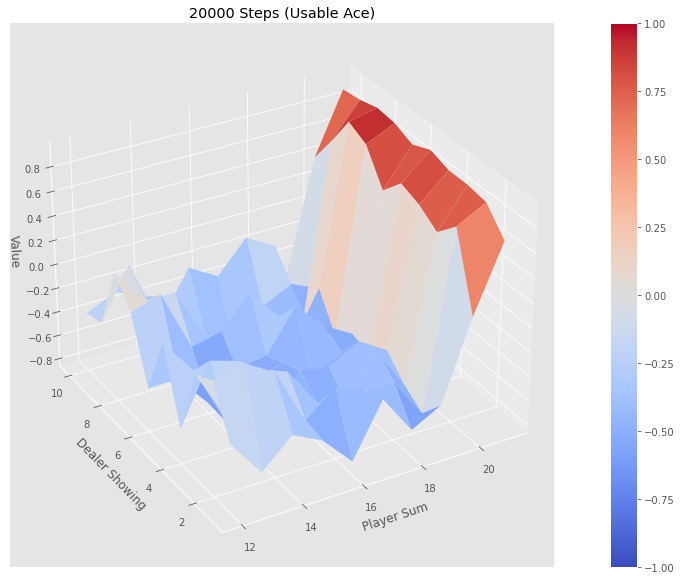

Episode 30000/200000.

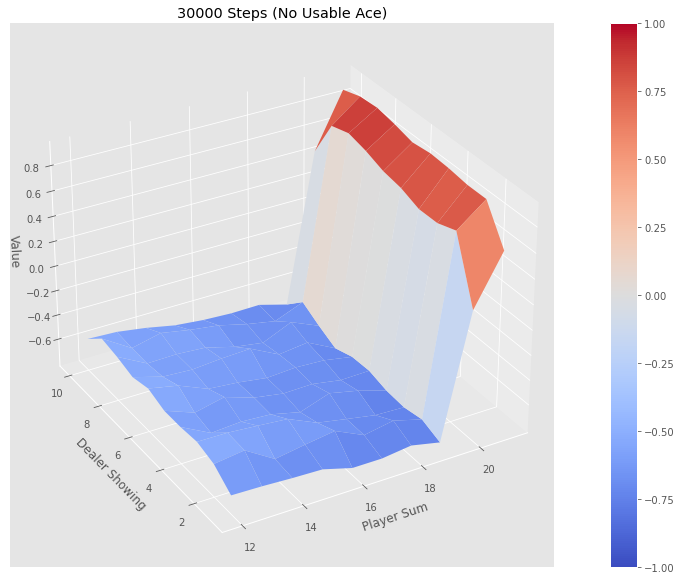

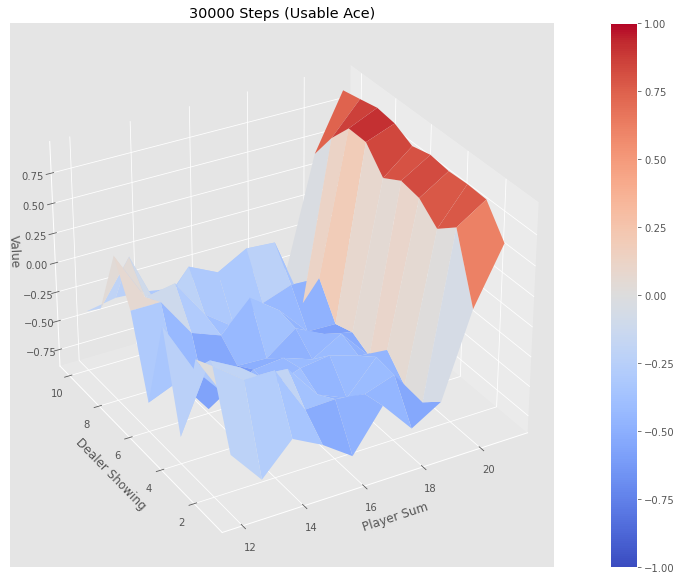

Episode 40000/200000.

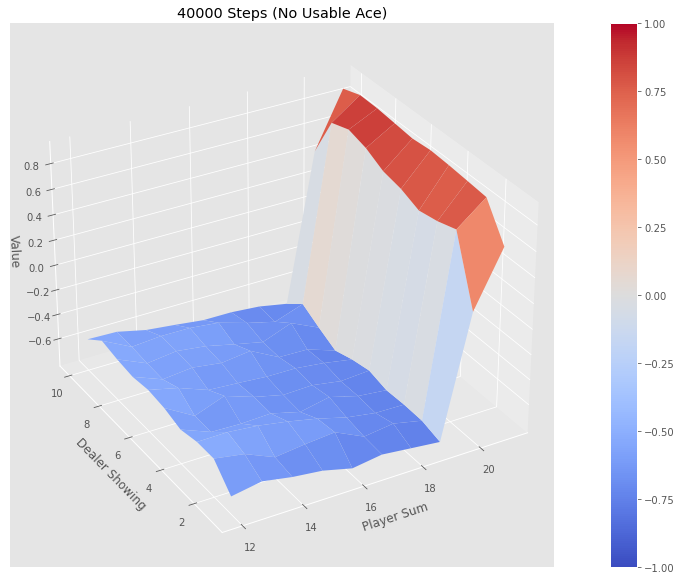

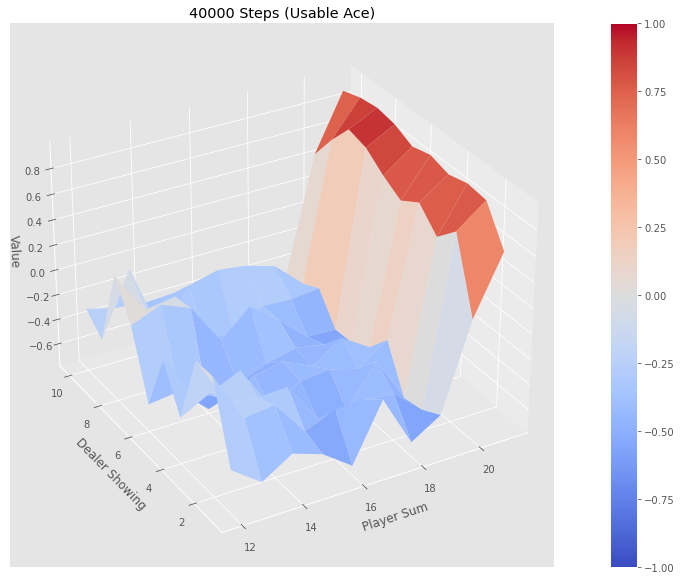

Episode 50000/200000.

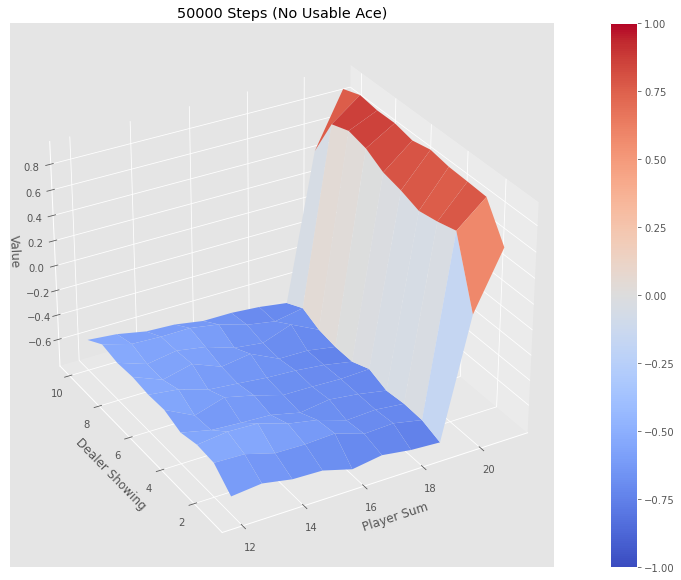

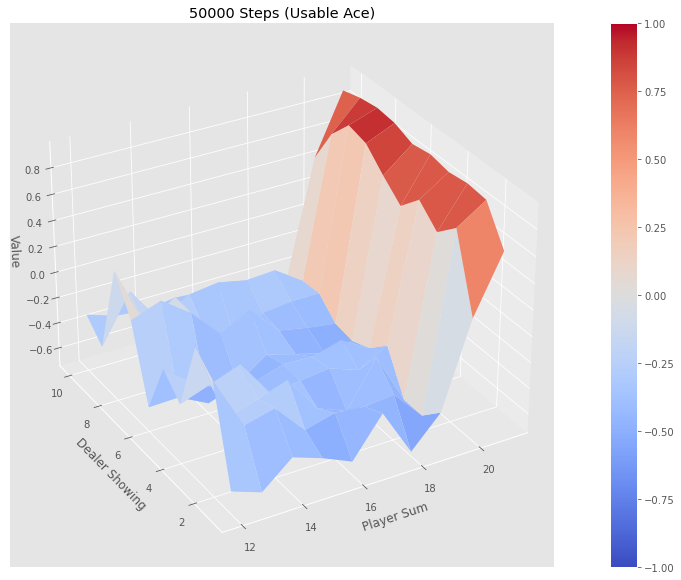

Episode 60000/200000.

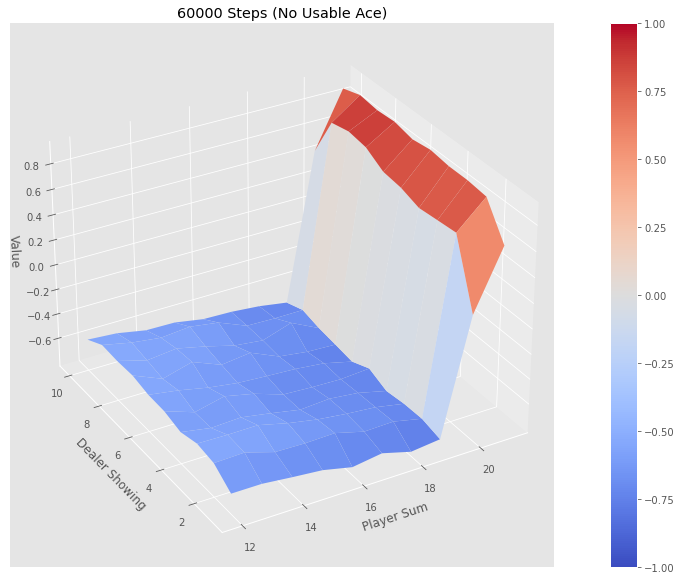

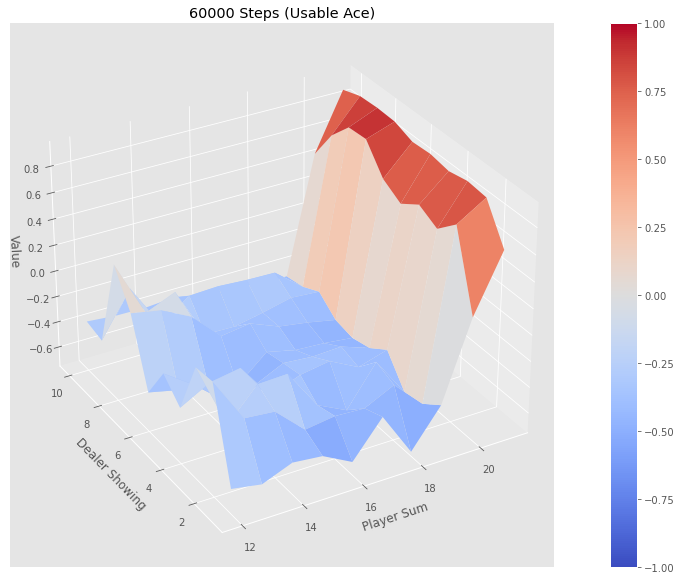

Episode 70000/200000.

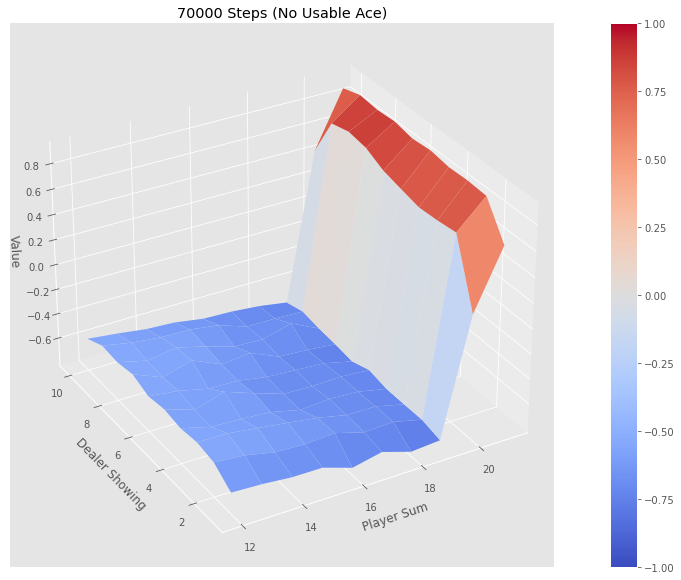

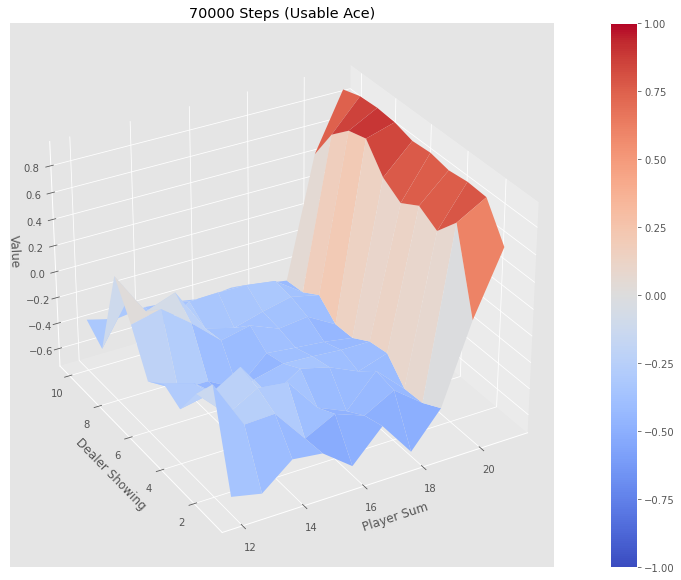

Episode 80000/200000.

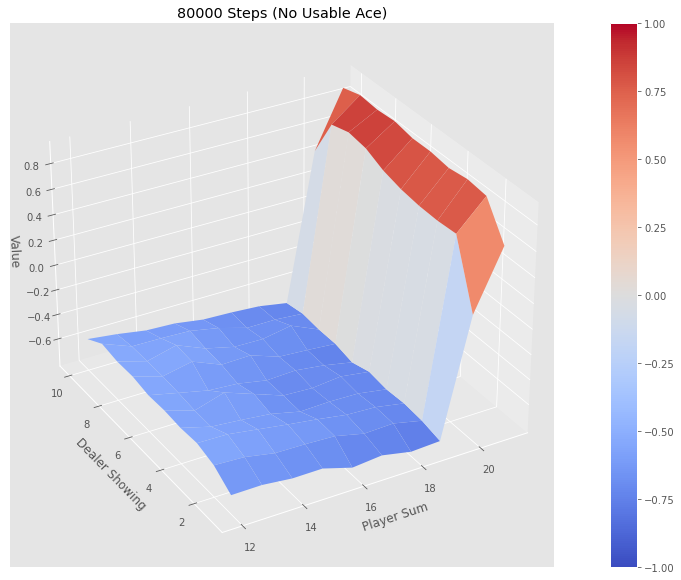

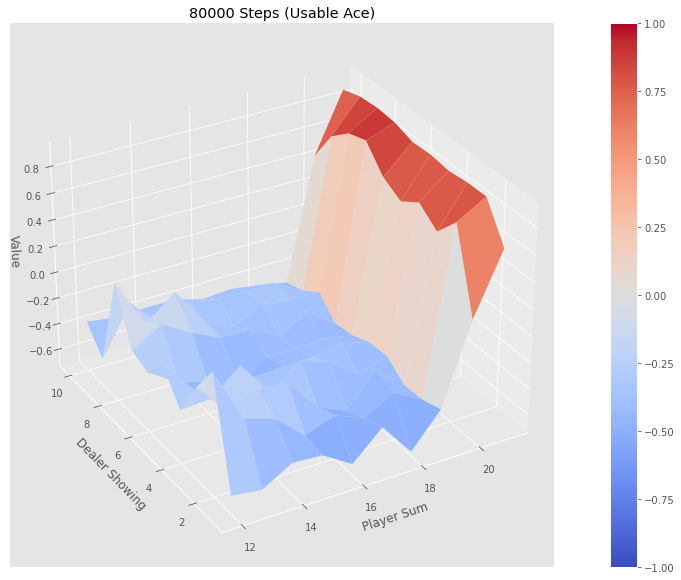

Episode 90000/200000.

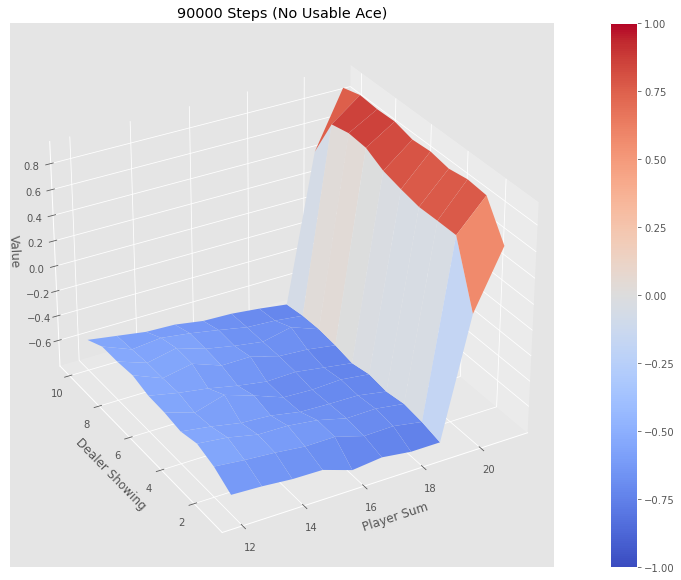

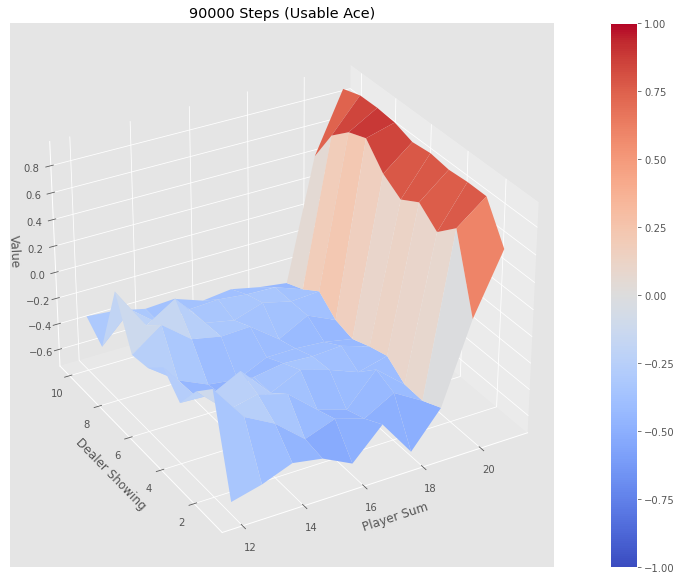

Episode 100000/200000.

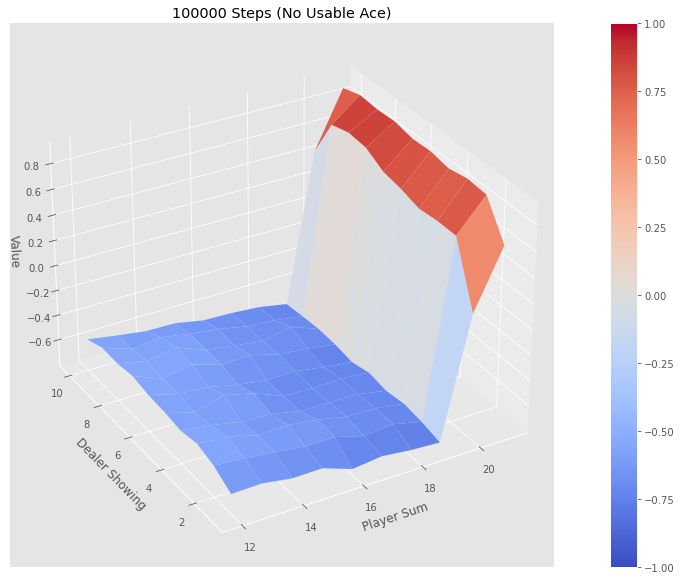

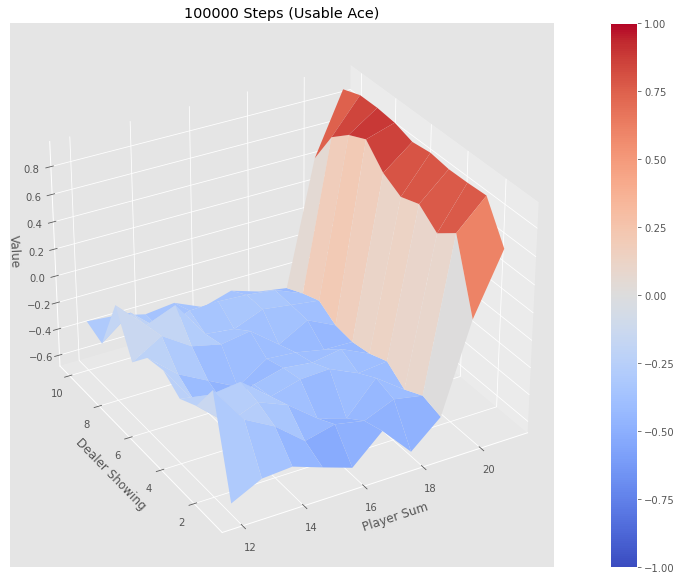

Episode 110000/200000.

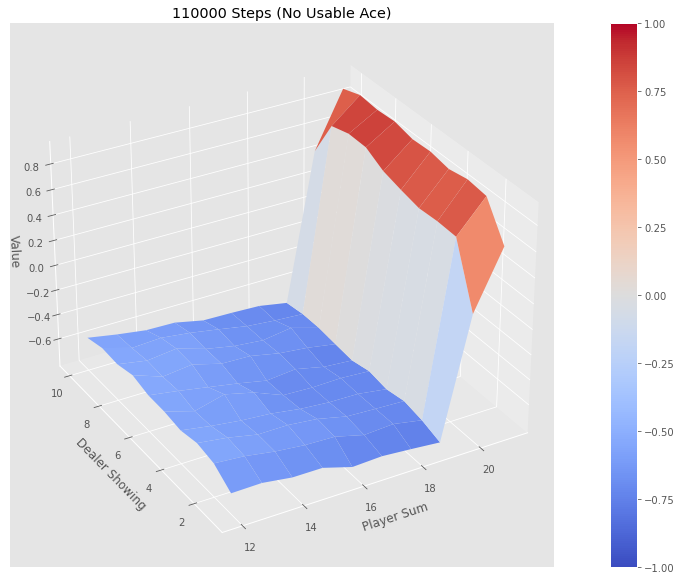

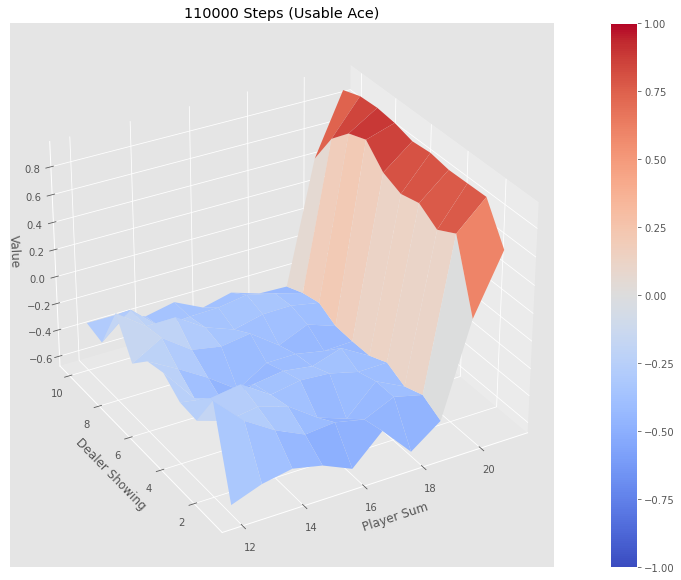

Episode 120000/200000.

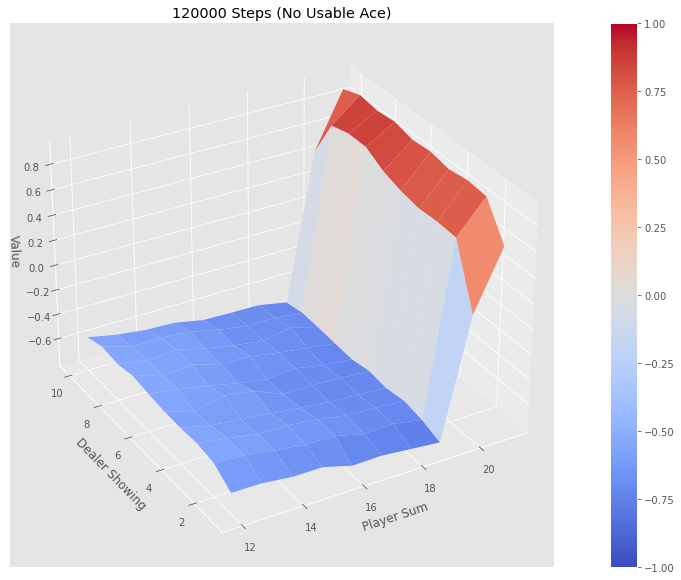

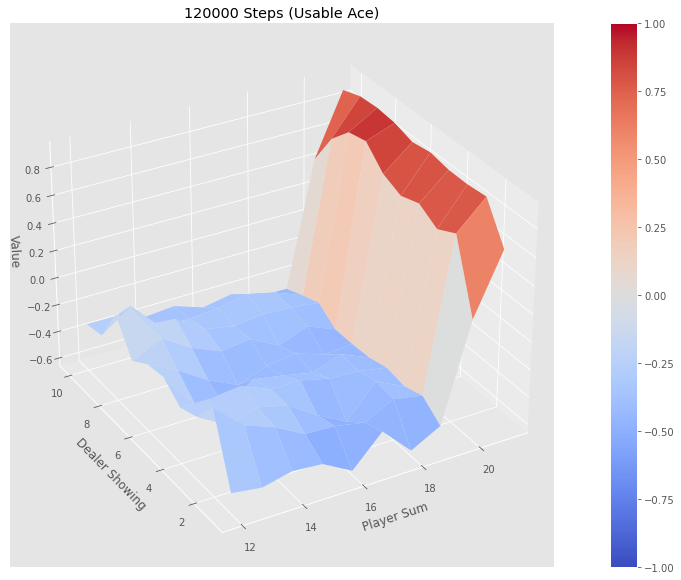

Episode 130000/200000.

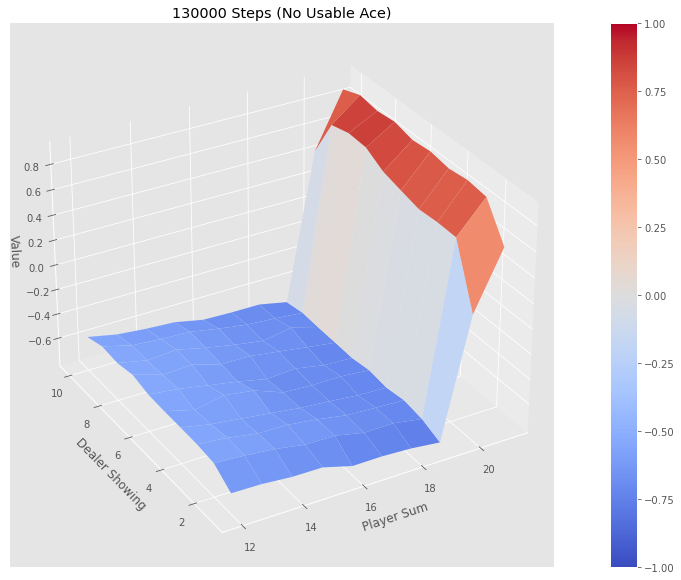

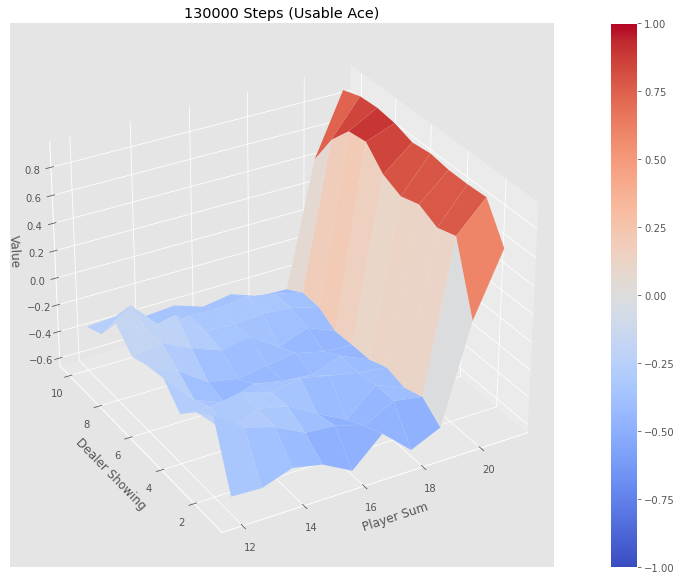

Episode 140000/200000.

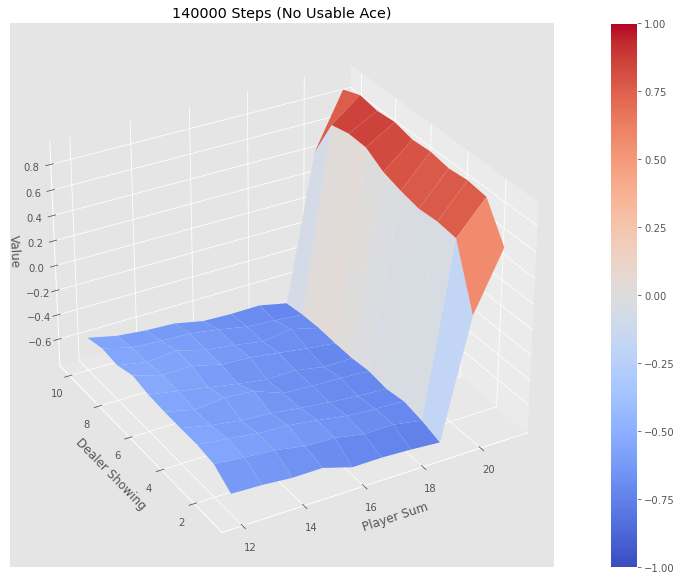

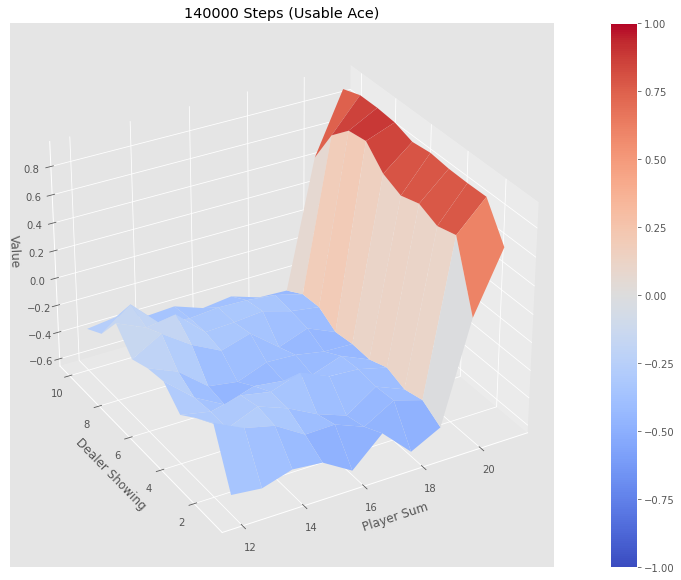

Episode 150000/200000.

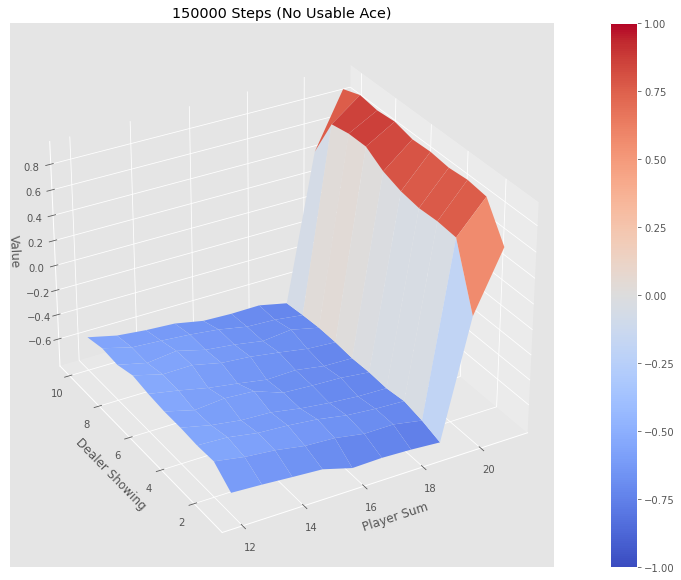

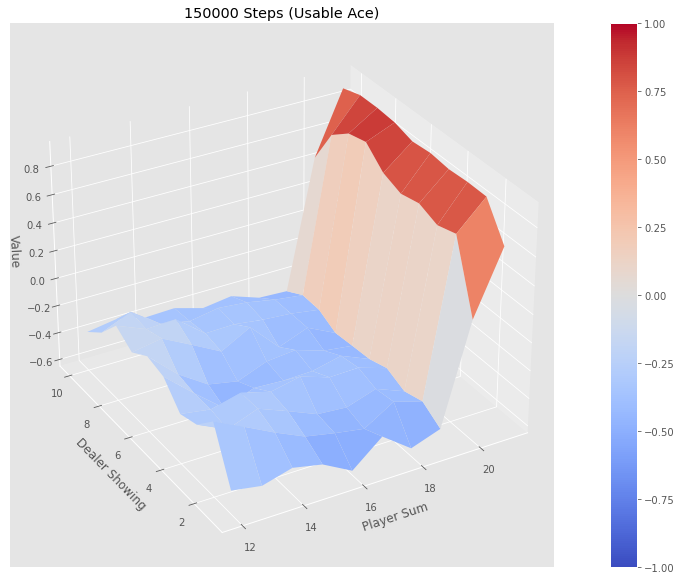

Episode 160000/200000.

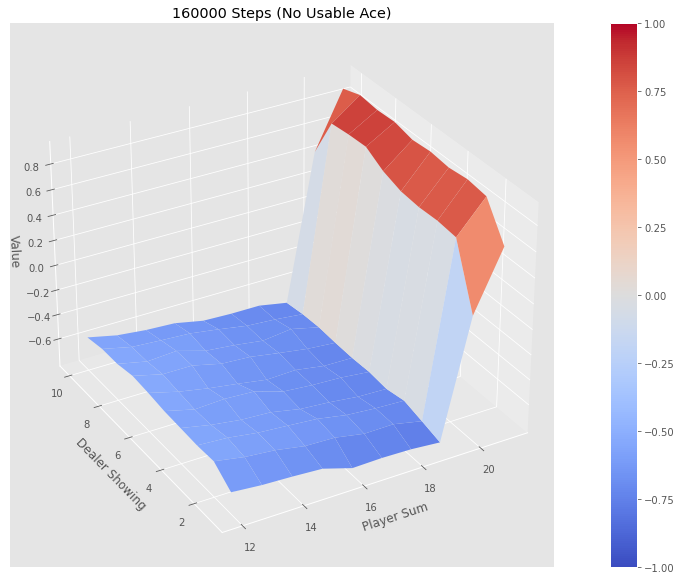

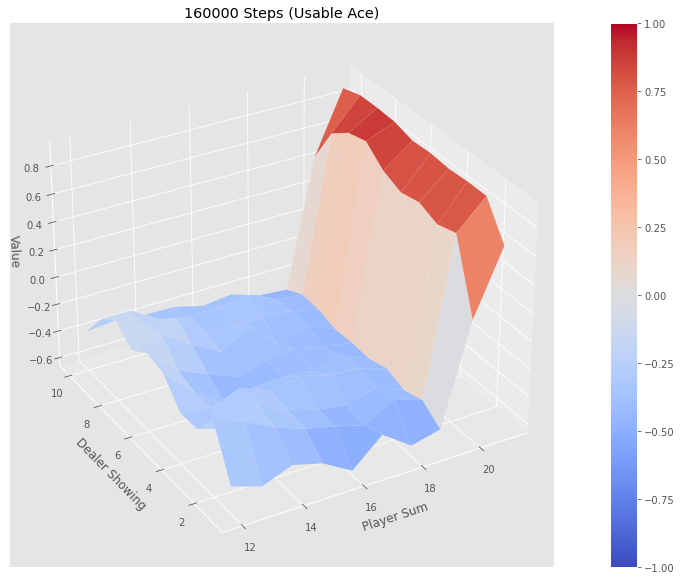

Episode 170000/200000.

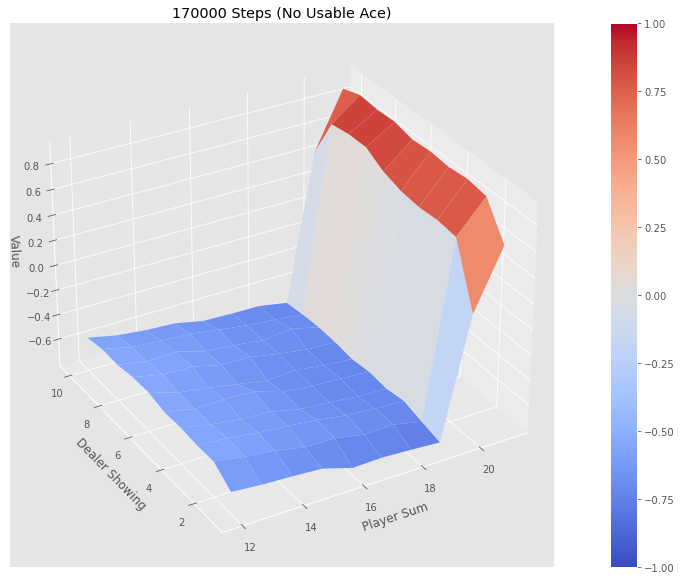

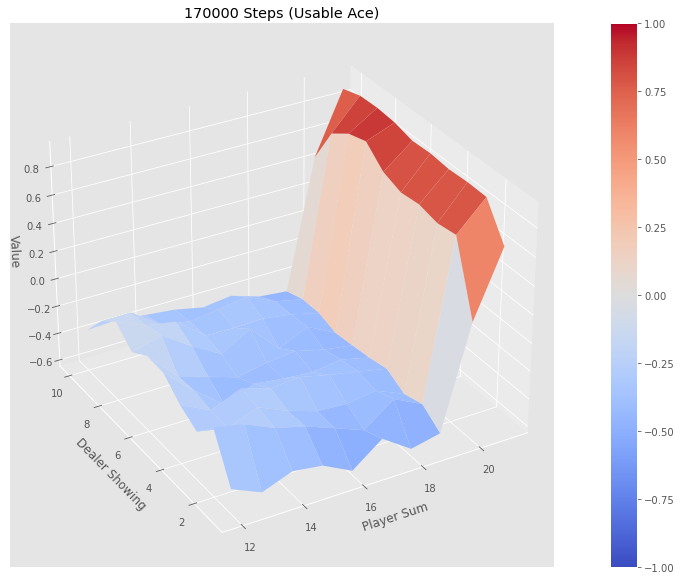

Episode 180000/200000.

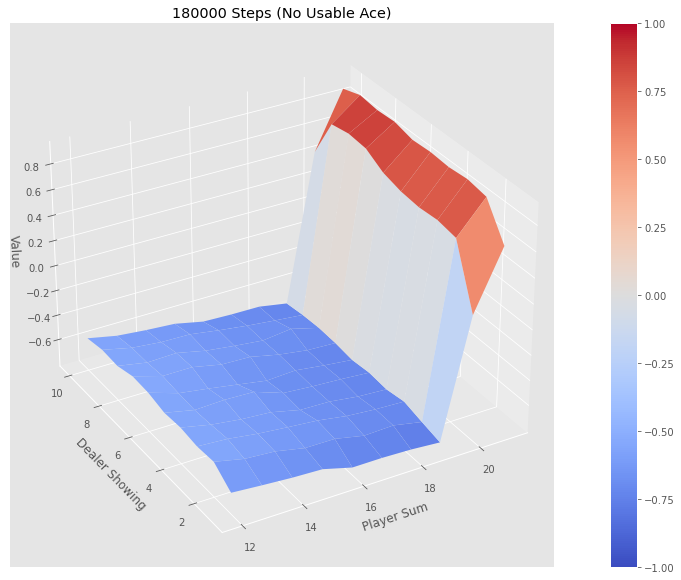

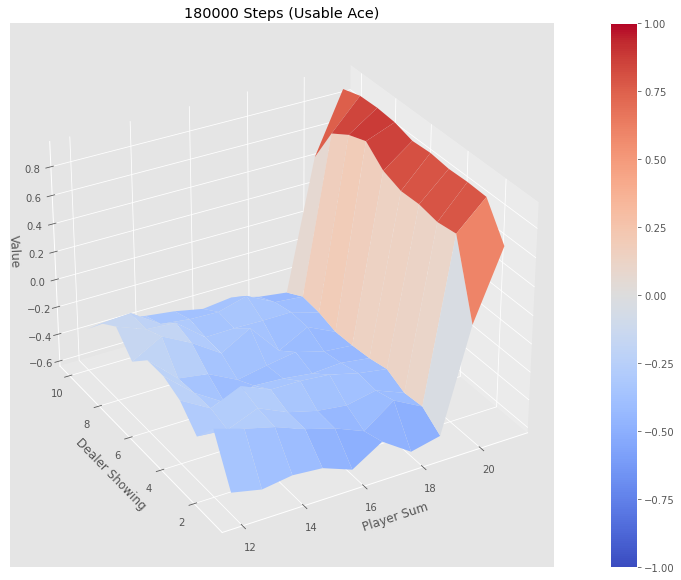

Episode 190000/200000.

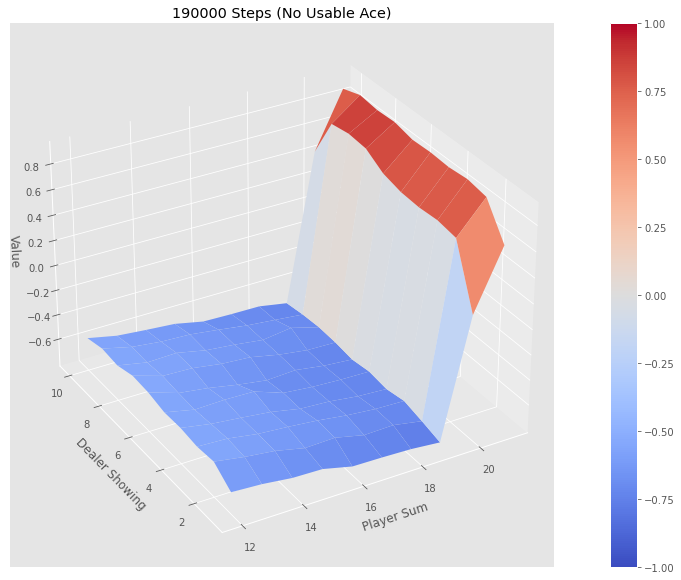

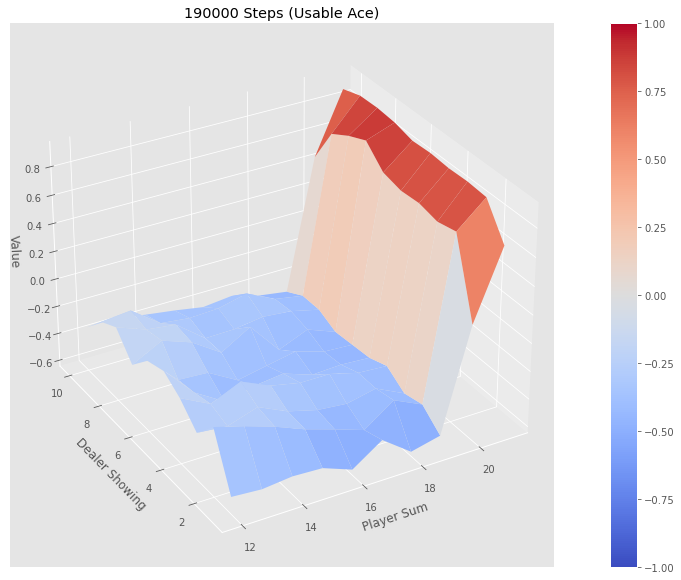

Episode 200000/200000.

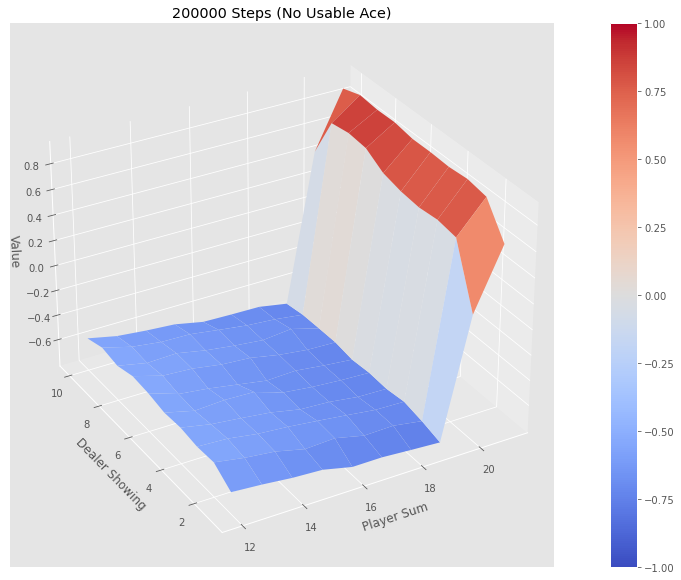

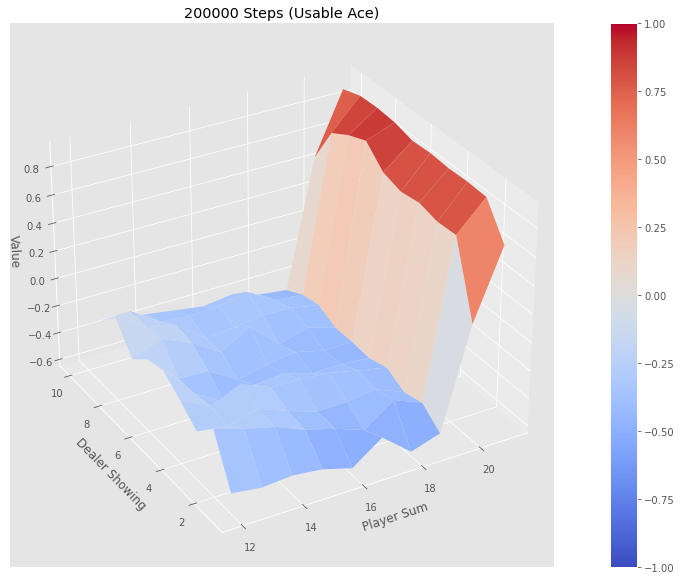

In [8]:
V_20k = mc_prediction(sample_policy, env, num_episodes=200000, plot_every=10000)

## Question 
What's the effect of the number of episodes (num_episodes) on the learned value function ?

Answer: 


# RL Lab 03 - Part 2 - TD prediction on Random walk and BlackJack

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

From Sutton and Barto (chapter 6.1), the TD(0) algorithm for estimating V is as follows:
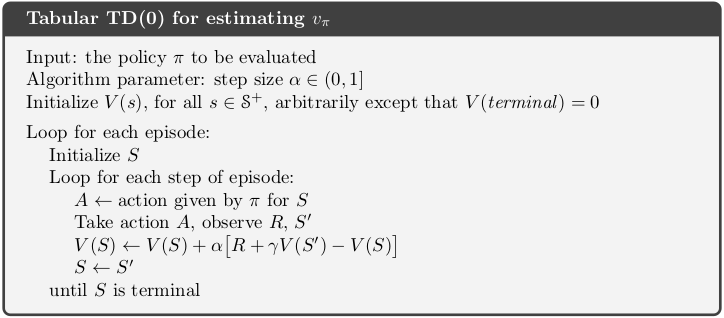


### Implementation of TD(0)

Start by filling the following blanks in the code below:

In [23]:
def td_prediction(env, policy, ep, gamma, alpha):
    """TD Prediction
    
    Params:
        env - environment
        ep - number of episodes to run
        policy - function in form: policy(state) -> action
        gamma - discount factor [0..1]
        alpha - step size (0..1]
    """
    assert 0 < alpha <= 1
    V = defaultdict(float)    # default value 0 for all states
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S)
            S_, R, done = env.step(A)
            V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S])
            S = S_
            if done: break
                
    return V

For TD prediction to work, **V for terminal states must be equal to
zero, always**. Value of terminal states is zero because game is over
and there is no more reward to get. Value of next-to-last state is
reward for last transition only, and so on.

-   If terminal state is initalised to something different than zero,
    then your resulting V estimates will be offset by that much
-   If, V of terminal state is *updated during training*
    then everything will go wrong.
    -   so make *absolutely sure* environment returns different
        observations for terminal states than non-terminal ones
    -   hint: this is not the case for out-of-the-box gym Blackjack, so you need to change it

## Evaluate a Random walk (example 6.2 Sutton's book)

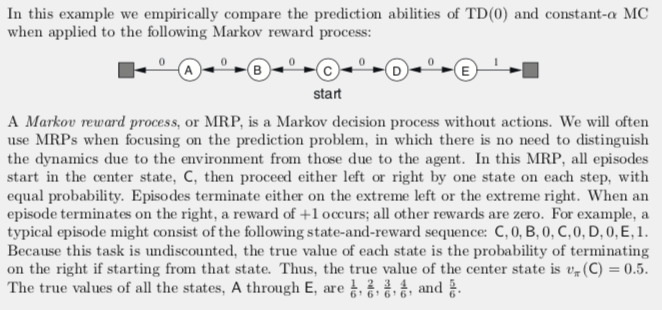

In [24]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self._state = 3
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
                
        return self._state, reward, self._done  # obs, rew, done

In [25]:
env = LinearEnv()

Plotting helper function:

In [26]:
def plot(V_dict):
    """Param V is dictionary int[0..7]->float"""
    
    V_arr = np.zeros(7)
    for st in range(7):
        V_arr[st] = V_dict[st]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LinearEnv.V_true[1:-1], color='black', label='V true')
    ax.plot(V_arr[1:-1], label='V')
    
    ax.legend()
    
    plt.show()

Random policy:

In [27]:
def policy(state):
    return np.random.choice([0, 1])  # random policy

#### For 10 episodes

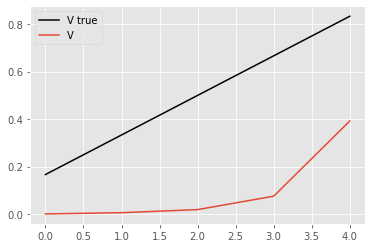

In [28]:
V = td_prediction(env, policy, ep=10, gamma=1.0, alpha=0.1)
plot(V)

#### For 1000 episodes 

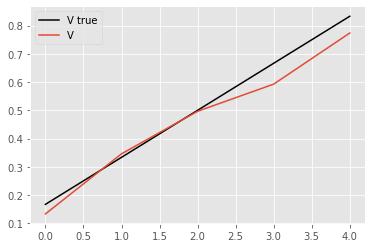

In [29]:
V = td_prediction(env, policy, ep=1000, gamma=1.0, alpha=0.1)
plot(V)

## Temporal-Difference for BlackJack

Let's start first by fixing the BlackJack environement for TD(0)

As mentioned earlier, there is a problem with Blackjack environment in the gym. If agent sticks, then environment will return exactly the same observation but this time with done==True. This will cause TD prediction to evaluate terminal state to non-zero value belonging to non-terminal state with same observation. We fix this by redefining observation for terminal states with 'TERMINAL'.


In [30]:
class BlackjackFixed():
    def __init__(self):
        self._env = gym.make('Blackjack-v1')
        
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        obs, rew, done, _ = self._env.step(action)
        if done:
            return 'TERMINAL', rew, True  # (obs, rew, done)         <-- SUPER IMPORTANT!!!!
        else:
            return obs, rew, done
        return self._env.step(action)

In [31]:
env = BlackjackFixed()

Naive policy for BlackJack. We keep the same as earlier: stick on 20 or more, hit otherwise.

In [35]:
def policy(St):
    p_sum, d_card, p_ace = St
    if p_sum >= 20:
        return 0  # stick
    else:
        return 1  # hit
    # Write the if statement for the policy, return 1 for a hit action and 0 for stick action # 


Plotting

In [36]:
def plot_blackjack(V_dict):
    def convert_to_arr(V_dict, has_ace):
        V_dict = defaultdict(float, V_dict)  # assume zero if no key
        V_arr = np.zeros([10, 10])  # Need zero-indexed array for plotting 
        for ps in range(12, 22):     # convert player sum from 12-21 to 0-9
            for dc in range(1, 11):  # convert dealer card from 1-10 to 0-9
                V_arr[ps-12, dc-1] = V_dict[(ps, dc, has_ace)]
        return V_arr

    def plot_3d_wireframe(axis, V_dict, has_ace):
        Z = convert_to_arr(V_dict, has_ace)
        dealer_card = list(range(1, 11))
        player_points = list(range(12, 22))
        X, Y = np.meshgrid(dealer_card, player_points)
        axis.plot_wireframe(X, Y, Z)

    fig = plt.figure(figsize=[16,3])
    ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
    ax_has_ace = fig.add_subplot(122, projection='3d', title='With Ace')
    ax_no_ace.set_xlabel('Dealer Showing'); ax_no_ace.set_ylabel('Player Sum')
    ax_has_ace.set_xlabel('Dealer Showing'); ax_has_ace.set_ylabel('Player Sum')
    plot_3d_wireframe(ax_no_ace, V_dict, has_ace=False)
    plot_3d_wireframe(ax_has_ace, V_dict, has_ace=True)
    plt.show()

Evaluate

In [37]:
V = td_prediction(env, policy, ep=50000, gamma=1.0, alpha=0.05)
plot_blackjack(V)

ValueError: not enough values to unpack (expected 3, got 2)

## TD vs MC comparison on Random Walk

We will need slightly extended version of TD prediction, so we can log V during training and initalise V to 0.5



In [38]:
def td_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):
    """TD Prediction
    
    Params:
        env - environment
        ep - number of episodes to run
        policy - function in form: policy(state) -> action
        gamma - discount factor [0..1]
        alpha - step size (0..1]
    """
    assert 0 < alpha <= 1
    
    # Change #1, allow initialisation to arbitrary values
    if V_init is not None:  V = V_init.copy()       # remember V of terminal states must be 0 !!
    else:                   V = defaultdict(float)  # default value 0 for all states
    
    V_hist = []
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S)
            S_, R, done = env.step(A)
            V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S])
            S = S_
            if done: break
        
        V_arr = [V[i] for i in range(7)]  # e.g. [0.0, 0.3, 0.4, 0.5, 0.6. 0.7, 0.0]
        V_hist.append(V_arr)  # dims: [ep_number, state]
                
    return V, np.array(V_hist)

Environment and policy

In [ ]:
env = LinearEnv()

In [ ]:
def policy(state):
    return np.random.choice([0, 1])  # random policy

In [ ]:
V_init = defaultdict(lambda: 0.5)   # init V to 0.5
V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!
V_n1, _ = td_prediction_ext(env, policy, ep=1, gamma=1.0, alpha=0.1, V_init=V_init)
V_n10, _ = td_prediction_ext(env, policy, ep=10, gamma=1.0, alpha=0.1, V_init=V_init)
V_n100, _ = td_prediction_ext(env, policy, ep=100, gamma=1.0, alpha=0.1, V_init=V_init)

def to_arr(V_dict):
    """Param V is dictionary int[0..7]->float"""
    V_arr = np.zeros(7)
    for st in range(7):
        V_arr[st] = V_dict[st]
    return V_arr

V_n1 = to_arr(V_n1)
V_n10 = to_arr(V_n10)
V_n100 = to_arr(V_n100)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.zeros([7])[1:-1]+0.5, color='black', linewidth=0.5)
ax.plot(LinearEnv.V_true[1:-1], color='black', label='True Value')
ax.plot(V_n1[1:-1], color='red', label='n = 1')
ax.plot(V_n10[1:-1], color='green', label='n = 10')
ax.plot(V_n100[1:-1], color='blue', label='n = 100')
ax.set_title('Estimated Value')
ax.set_xlabel('State')
ax.legend()

# plt.savefig('assets/fig_0601a')
plt.show()

## Question: 
Interpret the graph above.

Answer: 

## We define a running mean MC algorithm. 

In [ ]:
def mc_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):
    """Running Mean MC Prediction
    Params:
        env - environment
        policy - function in a form: policy(state)->action
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1)
        V_init - inial V
    """
    if V_init is not None:  V = V_init.copy()
    else:                   V = defaultdict(float)  # default value 0 for all states
    
    V_hist = []
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            V[St] = V[St] + alpha * (G - V[St])
            
        V_arr = [V[i] for i in range(7)]  # e.g. [0.0, 0.3, 0.4, 0.5, 0.6. 0.7, 0.0]
        V_hist.append(V_arr)  # dims: [ep_number, state]
        
    return V, np.array(V_hist)

In [ ]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

For each line on a plot, we need to run algorithm multitple times and then calculate root-mean-squared-error over all runs properly. Let's define helper function to do all that.



In [ ]:
def run_experiment(algorithm, nb_runs, env, ep, policy, gamma, alpha):
    V_init = defaultdict(lambda: 0.5)   # init V to 0.5
    V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!

    V_runs = []
    for i in range(nb_runs):
        _, V_hist = algorithm(env, policy, ep, gamma=gamma, alpha=alpha, V_init=V_init)
        V_runs.append(V_hist)
    V_runs = np.array(V_runs)  # dims: [nb_runs, nb_episodes, nb_states=7]
    
    V_runs = V_runs[:,:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

And finally the experiments

In [ ]:
#                                             nb_runs      ep         gamma alpha
rmse_td_a15 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.15)
rmse_td_a10 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.10)
rmse_td_a05 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.05)
rmse_mc_a04 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.04)
rmse_mc_a03 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.03)
rmse_mc_a02 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.02)
rmse_mc_a01 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.01)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rmse_mc_a04, color='red', linestyle='-', label='MC a=.04')
ax.plot(rmse_mc_a03, color='red', linestyle='--', label='MC a=.03')
ax.plot(rmse_mc_a02, color='red', linestyle=':', label='MC a=.02')
ax.plot(rmse_mc_a01, color='red', linestyle='-', label='MC a=.01')
ax.plot(rmse_td_a15, color='blue', linestyle='-', label='TD a=.15')
ax.plot(rmse_td_a10, color='blue', linestyle='--', label='TD a=.10')
ax.plot(rmse_td_a05, color='blue', linestyle=':', label='TD a=.05')
ax.set_title('Empirical RMS error, averaged over tests')
ax.set_xlabel('Walks / Episodes')
ax.legend()
plt.tight_layout()
# plt.savefig('assets/fig_0601b.png')
plt.show()

## Question
Interpret the graph above.

Answer: